In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'bids16-machine-learning:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F68885%2F7645460%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240228%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240228T100145Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D04fc00095c8ee62d15debb1245f8e18371d0e0dd151f0f30054d3cfc155ee407d7a56af1c4cc46bc0d97b838cf00948a70fe2a39dcec3c6feb0462f022c6f61c3178a2d40073e8f3b548a381ce59a93c663cd29bc58f70843818098a3fdce0790452a37518eb1dadafd695c7d42eff3c2d5e5f070643237408355965ab5b03684b1acd8ce99b8ddedcd1393c589ba2e2ea99e08bb05b5ec6789e683c7418a2935178eac93e3bc9cc29a06f84e1ea60ea8768437261406254feba5993076420593c875c740446c3fec619e64b723500a7879353980b81049a39ff6ecf217bf8e8c8205f6c2e32dc4c52fed8f711b26e74b8f7bec7bee2e8e6fa7ec57acfad1b28'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 15050 bytes downloaded
Downloaded and uncompressed: bids16-machine-learning
Data source import complete.


# Kaggle challenge Yoav Yosef

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf4
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
import math

In [ ]:
# Reading the data, and assigning it to "df"
df_train = pd.read_csv('/kaggle/input/bids16-machine-learning/train.csv')
df_test = pd.read_csv('/kaggle/input/bids16-machine-learning/test.csv')

In [ ]:
df_train.head()

,id,season,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,1,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,985
1,2,1,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,801
2,3,1,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,1349
3,4,1,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,1562
4,5,1,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,1600


In [ ]:
# Copying the train and test data sets to perform tests and feature engineering
df_train_copy = df_train.copy()
df_test_copy = df_test.copy()

In [ ]:
# Dropping 'id' column since it's not required for prediction
df_train_copy = df_train_copy.drop(columns=['id'])
df_test_copy = df_test_copy.drop(columns=['id'])

In [ ]:
df_train_copy.columns

Index(['season', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit',
       'temp', 'atemp', 'hum', 'windspeed', 'cnt'],
      dtype='object')

In [ ]:
# Create a list containing the numbers from 1 to 4 (representing seasons)
range_season = list(range(1, 5))

# Calculate the mean temperature for each season
season_mean = df_train_copy.groupby('season')['temp'].mean()

# Create a new column for average temperature per season
df_train_copy['temp_mean_by_season'] = df_train_copy['season'].map(season_mean)
df_test_copy['temp_mean_by_season'] = df_test_copy['season'].map(season_mean)

# Create a list containing the numbers from 1 to 4 (representing seasons)
range_weathersit = list(range(1, 5))

# Calculate the mean temperature for each season
weathersit_mean = df_train_copy.groupby('weathersit')['temp'].mean()

# Create a new column for average temperature per season
df_train_copy['temp_mean_by_weathersit'] = df_train_copy['weathersit'].map(weathersit_mean)
df_test_copy['temp_mean_by_weathersit'] = df_test_copy['weathersit'].map(weathersit_mean)



In [ ]:
column_names_train = df_train_copy.columns.tolist()
column_names_test = df_test_copy.columns.tolist()
print(column_names_train)
print(column_names_test)

['season', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'cnt', 'temp_mean_by_season', 'temp_mean_by_weathersit']
['season', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'temp_mean_by_season', 'temp_mean_by_weathersit']


In [ ]:
# Function to calculate wind chill index (WCI) / wind chill factor (WCF)
def wind_chill_index(temp, windspeed):
  """
  Calculates the wind chill index using a generic formula with unit scaling.

  Args:
      temp (float): Temperature value (unit unknown).
      windspeed (float): Wind speed value (unit unknown).

  Returns:
      float: Wind chill index in the same unit scale as the input values.
  """

  # Scaling factors (adjust these if you know the actual units)
  temp_scale = 10  # Assuming temperature is in tens of a degree (e.g., 0.25 represents 2.5 degrees)
  wind_scale = 10  # Assuming wind speed is in tenths of m/s (e.g., 0.35 represents 3.5 m/s)

  # Calculate scaled values
  scaled_temp = temp * temp_scale
  scaled_windspeed = windspeed * wind_scale

  # Wind chill formula (applicable for temperatures below 10°C)
  wind_chill = 35.74 + 0.6215 * scaled_temp - 35.75 * (scaled_windspeed ** 0.16) + 0.4275 * scaled_temp * (scaled_windspeed ** 0.16)

  # Rescale wind chill to match input unit scale
  wind_chill_scaled = wind_chill / (temp_scale * wind_scale)

  return wind_chill_scaled


In [ ]:
# Feature engineering with interactions 'temp' and 'atemp'
df_train_copy['feels_like_diff'] = df_train_copy['temp'] - df_train_copy['atemp']
df_test_copy['feels_like_diff'] = df_test_copy['temp'] - df_test_copy['atemp']

# Feature engineering with interactions 'temp' and 'atemp'
df_train_copy['feels_like_ratio'] = df_train_copy['temp'] / df_train_copy['atemp']
df_test_copy['feels_like_ratio'] = df_test_copy['temp'] / df_test_copy['atemp']

# 'temp' and 'hum'
df_train_copy['temp_hum_interaction'] = df_train_copy['temp'] * df_train_copy['hum']
df_test_copy['temp_hum_interaction'] = df_test_copy['temp'] * df_test_copy['hum']

# 'hum' 'temp' ratio
df_train_copy['hum_temp_ratio'] = df_train_copy['hum'] / df_train_copy['temp']
df_test_copy['hum_temp_ratio'] = df_test_copy['hum'] / df_test_copy['temp']

# Wind chill
df_train_copy['windchill_index'] = wind_chill_index(df_train_copy['temp'], df_train_copy['windspeed'])
df_test_copy['windchill_index'] = wind_chill_index(df_test_copy['temp'], df_test_copy['windspeed'])

# Transformation features for 'temp'
df_train_copy['temp_log'] = np.log(df_train_copy['temp'])
df_test_copy['temp_log'] = np.log(df_test_copy['temp'])

In [ ]:
print(df_train_copy.columns)
print(df_test_copy.columns)
print(len(df_train_copy.columns))
print(len(df_test_copy.columns))

Index(['season', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit',
       'temp', 'atemp', 'hum', 'windspeed', 'cnt', 'temp_mean_by_season',
       'temp_mean_by_weathersit', 'feels_like_diff', 'feels_like_ratio',
       'temp_hum_interaction', 'hum_temp_ratio', 'windchill_index',
       'temp_log'],
      dtype='object')
Index(['season', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit',
       'temp', 'atemp', 'hum', 'windspeed', 'temp_mean_by_season',
       'temp_mean_by_weathersit', 'feels_like_diff', 'feels_like_ratio',
       'temp_hum_interaction', 'hum_temp_ratio', 'windchill_index',
       'temp_log'],
      dtype='object')
19
18


In [ ]:
# Dropping 'holiday' column since it's not required for prediction
df_train_copy = df_train_copy.drop(columns=['holiday'])
df_test_copy = df_test_copy.drop(columns=['holiday'])

In [ ]:
def categorize_temperature_by_season_simple(temp, season, temp_mean):
  """
  Categorizes temperature as "cold", "normal", or "hot" based on season and mean temperature.

  Args:
      temp (float): Temperature value.
      season (int): Season value (0, 1, 2, 3).
      temp_mean (float): Average temperature for the given season.

  Returns:
      str: Categorization of the temperature ("cold", "normal", or "hot").
  """

  if temp < temp_mean * 0.1:  # Cold (10th percentile threshold)
    return "0"
  elif temp > temp_mean * 0.9:  # Hot (90th percentile threshold)
    return "2"
  else:
    return "1"  # Normal

# Apply the function element-wise using `.apply()`
df_train_copy['hot_cold_for_season'] = df_train_copy[['temp', 'season', 'temp_mean_by_season']].apply(lambda row: categorize_temperature_by_season_simple(*row), axis=1)
df_test_copy['hot_cold_for_season'] = df_test_copy[['temp', 'season', 'temp_mean_by_season']].apply(lambda row: categorize_temperature_by_season_simple(*row), axis=1)


In [ ]:
print(df_train_copy.columns)
print(df_train_copy.dtypes)

Index(['season', 'mnth', 'weekday', 'workingday', 'weathersit', 'temp',
       'atemp', 'hum', 'windspeed', 'cnt', 'temp_mean_by_season',
       'temp_mean_by_weathersit', 'feels_like_diff', 'feels_like_ratio',
       'temp_hum_interaction', 'hum_temp_ratio', 'windchill_index', 'temp_log',
       'hot_cold_for_season'],
      dtype='object')
season                       int64
mnth                         int64
weekday                      int64
workingday                   int64
weathersit                   int64
temp                       float64
atemp                      float64
hum                        float64
windspeed                  float64
cnt                          int64
temp_mean_by_season        float64
temp_mean_by_weathersit    float64
feels_like_diff            float64
feels_like_ratio           float64
temp_hum_interaction       float64
hum_temp_ratio             float64
windchill_index            float64
temp_log                   float64
hot_cold_for_season       

In [ ]:
print(df_train_copy['weekday'].unique())
print(df_train_copy['mnth'].unique())

[6 0 1 2 3 4 5]
[ 1  2  3  4  5  6  7  8  9 10 11 12]


In [ ]:
def add_week_within_month(df, month_col, day_col, week_col):
  """
  Adds a new feature indicating the week within the month (1-4 or 5).

  Args:
      df (pd.DataFrame): Input DataFrame containing month, day, and year columns.
      month_col (str): Name of the column containing month strings.
      day_col (str): Name of the column containing day of week values (0-6).
      week_col (str): Name of the column to store the week within month values.
  """

  # Assuming year information is available elsewhere (e.g., another column or external source)
  # Modify this part based on how you'll access the year data
  year = 2024  # Replace with your logic to retrieve the year

  # Define a function to calculate the week within the month
  def get_week_within_month(row):
    month_str = row[month_col]  # Use the month string directly
    day = row[day_col] + 1  # Add 1 to convert day of week from 0-6 to 1-7
    # ... rest of the logic using month_str and day ...
    return week_num


def add_quarter(df, month_col, quarter_col):
  """
  Adds a new feature indicating the quarter of the year (1-4).

  Args:
      df (pd.DataFrame): Input DataFrame containing month column.
      month_col (str): Name of the column containing month values (1-12).
      quarter_col (str): Name of the column to store the quarter values.
  """

  df[quarter_col] = (df[month_col] - 1) // 3 + 1

# Example usage:

# Assuming you have 'month', 'day_of_month', and 'year' columns in your DataFrames
add_week_within_month(df_train_copy, df_train_copy['mnth'], df_train_copy['weekday'], 'week_within_month')
add_quarter(df_train_copy, df_train_copy['mnth'], 'quarter')

add_week_within_month(df_test_copy, df_test_copy['mnth'], df_test_copy['weekday'], 'week_within_month')
add_quarter(df_test_copy, df_test_copy['mnth'], 'quarter')


KeyError: "None of [Int64Index([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,\n            ...\n            12, 12, 12, 12, 12, 12, 12, 12, 12, 12],\n           dtype='int64', length=365)] are in the [columns]"

In [ ]:
# Dropping 'holiday' column since it's not required for prediction
#df_train_copy = df_train_copy.drop(columns=['hum', 'windspeed', 'atemp'])
#df_test_copy = df_test_copy.drop(columns=['hum', 'windspeed', 'atemp'])
df_train_copy = df_train_copy.drop(columns=['atemp'])
df_test_copy = df_test_copy.drop(columns=['atemp'])



In [ ]:
# Dropping 'holiday' column since it's not required for prediction
#df_train_copy = df_train_copy.drop(columns=['temp_mean_by_month'])
#df_test_copy = df_test_copy.drop(columns=['temp_mean_by_month'])

In [ ]:
print(df_train_copy.columns)

Index(['season', 'mnth', 'weekday', 'workingday', 'weathersit', 'temp',
       'atemp', 'cnt', 'temp_mean_by_season', 'temp_mean_by_weathersit',
       'feels_like_diff', 'feels_like_ratio', 'temp_hum_interaction',
       'hum_temp_ratio', 'windchill_index', 'temp_log', 'hot_cold_for_season'],
      dtype='object')


In [ ]:
df_train_copy['hot_cold_for_season']

In [ ]:
categorical_features = ['season', 'mnth', 'workingday', 'weathersit', 'hot_cold_for_season']
continuous_features = ['cnt', 'temp', 'feels_like_diff', 'feels_like_ratio', 'temp_hum_interaction', 'hum_temp_ratio',
                       'windchill_index', 'temp_log']

In [ ]:
# Preprocess data
def preprocess_data(train_df, test_df):
    # List of features to be one-hot encoded
    one_hot_features = ['season', 'mnth']

    # Select categorical and continuous features in training set
    train_categorical = train_df[one_hot_features]
    train_numerical = train_df[continuous_features]

    # Select categorical and continuous features in test set
    test_categorical = test_df[one_hot_features]

    # Create a new list of continuous features excluding 'cnt'
    test_continuous_features = [feature for feature in continuous_features if feature != 'cnt']

    # Select continuous features for the test set based on the new list
    test_numerical = test_df[test_continuous_features]

    # Encode categorical features using pd.get_dummies() with 'category' dtype for both sets
    train_encoded = pd.get_dummies(train_categorical, columns=one_hot_features)
    test_encoded = pd.get_dummies(test_categorical, columns=one_hot_features)

    # Convert boolean values to integers for both sets
    train_encoded = train_encoded.astype(int)
    test_encoded = test_encoded.astype(int)

    # Concatenate numerical and encoded parts for both sets
    train_prepared = pd.concat([train_numerical, train_encoded], axis=1)
    test_prepared = pd.concat([test_numerical, test_encoded], axis=1)

    return train_prepared, test_prepared


df_train_prepared, df_test_prepared = preprocess_data(df_train_copy, df_test_copy)


In [ ]:
# Label Encoding 'weathersit'
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder object
encoder = LabelEncoder()

# Encode the 'weathersit' feature
train_label_encode = encoder.fit_transform(df_train_copy['weathersit'])
test_label_encode = encoder.fit_transform(df_test_copy['weathersit'])

# concat to df_train/test_prepared
df_train_prepared['label_encode_weathersit'] = train_label_encode
df_test_prepared['label_encode_weathersit'] = test_label_encode

In [ ]:
df_train_prepared.head().T

,0,1,2,3,4
cnt,985.000000,801.000000,1349.000000,1562.000000,1600.000000
temp,0.344167,0.363478,0.196364,0.200000,0.226957
atemp,0.363625,0.353739,0.189405,0.212122,0.229270
feels_like_diff,-0.019458,0.009739,0.006959,-0.012122,-0.002313
feels_like_ratio,0.946489,1.027532,1.036741,0.942854,0.989911
temp_hum_interaction,0.277341,0.253012,0.085865,0.118087,0.099170
hum_temp_ratio,2.341401,1.915073,2.226849,2.952175,1.925285
windchill_index,0.009067,-0.015595,-0.034186,-0.006484,-0.012895
temp_log,-1.066628,-1.012037,-1.627785,-1.609438,-1.482995
season_1,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
for var in categorical_features:
    value_counts = df_train_copy[var].value_counts()
    print(f"Unique values for {var}:\n{value_counts}\n")


Unique values for season:
3    94
2    92
1    90
4    89
Name: season, dtype: int64

Unique values for mnth:
1     31
3     31
5     31
7     31
8     31
10    31
12    31
4     30
6     30
9     30
11    30
2     28
Name: mnth, dtype: int64

Unique values for workingday:
1    250
0    115
Name: workingday, dtype: int64

Unique values for weathersit:
1    226
2    124
3     15
Name: weathersit, dtype: int64

Unique values for hot_cold_for_season:
2    250
1    115
Name: hot_cold_for_season, dtype: int64



In [ ]:
print(df_train_copy.columns)
print(df_test_copy.columns)

Index(['season', 'mnth', 'weekday', 'workingday', 'weathersit', 'temp',
       'atemp', 'cnt', 'temp_mean_by_season', 'temp_mean_by_weathersit',
       'feels_like_diff', 'feels_like_ratio', 'temp_hum_interaction',
       'hum_temp_ratio', 'windchill_index', 'temp_log', 'hot_cold_for_season'],
      dtype='object')
Index(['season', 'mnth', 'weekday', 'workingday', 'weathersit', 'temp',
       'atemp', 'temp_mean_by_season', 'temp_mean_by_weathersit',
       'feels_like_diff', 'feels_like_ratio', 'temp_hum_interaction',
       'hum_temp_ratio', 'windchill_index', 'temp_log', 'hot_cold_for_season'],
      dtype='object')


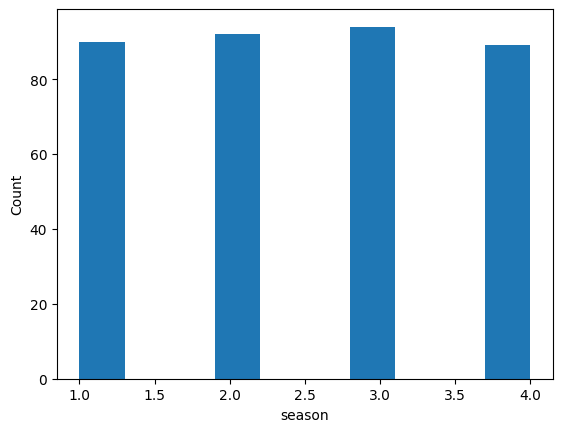

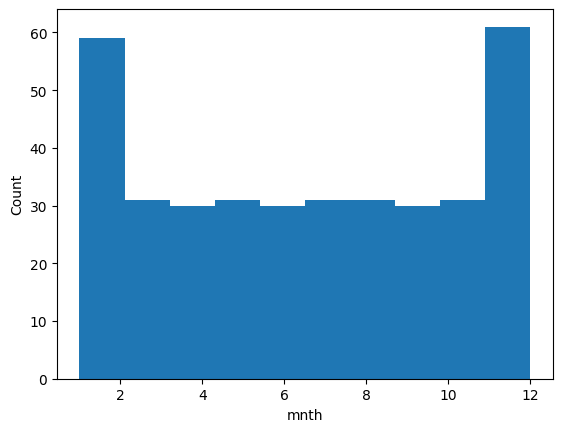

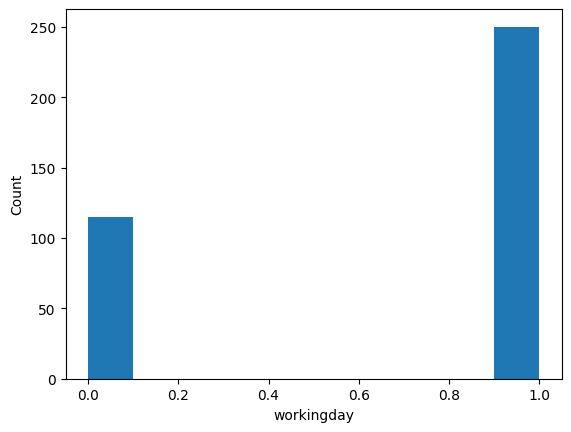

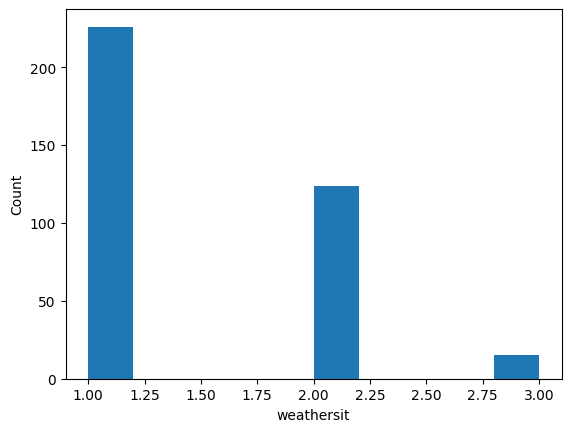

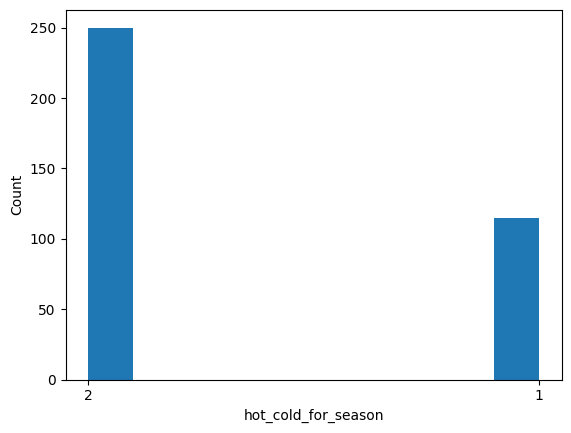

In [ ]:
# Assuming categorical_features is a list of categorical variables
for var in df_train_copy[categorical_features]:
    plt.hist(df_train_copy[var])
    plt.xlabel(var)  # Set the label for the x-axis
    plt.ylabel('Count')  # Set the label for the y-axis
    plt.show()


In [ ]:
continuous_features = ['cnt', 'temp', 'atemp', 'hum', 'windspeed', 'feels_like_diff', 'feels_like_ratio', 'temp_hum_interaction', 'hum_temp_ratio',
                       'windchill_index', 'temp_log']
for var in df_train_copy[continuous_features]:
    plt.scatter(df_train_copy[var], df_train_copy['cnt'])  # Replace 'cnt' with the target variable
    plt.xlabel(var)
    plt.ylabel('cnt')  # Replace 'cnt' with the target variable
    plt.title(f'Scatter plot of {var} vs cnt')
    plt.show()


KeyError: "['hum', 'windspeed'] not in index"

In [ ]:
df_train_prepared.head().T

,0,1,2,3,4
cnt,985.000000,801.000000,1349.000000,1562.000000,1600.000000
temp,0.344167,0.363478,0.196364,0.200000,0.226957
atemp,0.363625,0.353739,0.189405,0.212122,0.229270
feels_like_diff,-0.019458,0.009739,0.006959,-0.012122,-0.002313
feels_like_ratio,0.946489,1.027532,1.036741,0.942854,0.989911
temp_hum_interaction,0.277341,0.253012,0.085865,0.118087,0.099170
hum_temp_ratio,2.341401,1.915073,2.226849,2.952175,1.925285
windchill_index,0.009067,-0.015595,-0.034186,-0.006484,-0.012895
temp_log,-1.066628,-1.012037,-1.627785,-1.609438,-1.482995
season_1,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
df_train_prepared.columns

Index(['cnt', 'temp', 'atemp', 'feels_like_diff', 'feels_like_ratio',
       'temp_hum_interaction', 'hum_temp_ratio', 'windchill_index', 'temp_log',
       'season_1', 'season_2', 'season_3', 'season_4', 'mnth_1', 'mnth_2',
       'mnth_3', 'mnth_4', 'mnth_5', 'mnth_6', 'mnth_7', 'mnth_8', 'mnth_9',
       'mnth_10', 'mnth_11', 'mnth_12', 'label_encode_weathersit'],
      dtype='object')

In [ ]:
# Explore data descriptively and visually
def explore_data(df):
    # Separate continuous and categorical features
    continuous_features = ['cnt', 'temp', 'atemp', 'feels_like_diff', 'feels_like_ratio', 'temp_hum_interaction', 'hum_temp_ratio',
                       'windchill_index', 'temp_log']
    categorical_features = [col for col in df.columns if col not in continuous_features]

    # Display descriptive statistics for continuous features
    #print(df[continuous_features].describe().T)

    # Pairplot for continuous features
    sns.pairplot(df[continuous_features])
    plt.show()

    # Correlation matrix for all features
    correlation_matrix = df.corr()
    sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
    plt.show()

    # Interaction plots for categorical variables
    for cat_feature in categorical_features:
        sns.catplot(x=cat_feature, y='cnt', data=df, kind='bar')
        plt.title(f'{cat_feature} vs cnt')
        plt.show()

explore_data(df_train_copy)

In [ ]:
def explore_correlation(df, x, y, z):
    # Scatter plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=x, y=y, data=df)
    plt.title(f'Scatter Plot of {x} vs {y}')
    plt.show()

    # Correlation matrix
    correlation_matrix = df[[x, y, z]].corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
    plt.title(f'Correlation Matrix of {x} and {y} and {z}')
    plt.show()

# Example usage
explore_correlation(df_train_copy, 'temp', 'atemp', 'cnt')
explore_correlation(df_train_copy, 'temp', 'feels_like_diff', 'cnt')
explore_correlation(df_train_copy, 'temp', 'hum_temp_ratio', 'cnt')
explore_correlation(df_train_copy, 'temp', 'windchill_index', 'cnt')
explore_correlation(df_train_copy, 'temp', 'temp_hum_interaction', 'cnt')
explore_correlation(df_train_copy, 'temp', 'hum', 'cnt')
explore_correlation(df_train_copy, 'temp', 'windspeed', 'cnt')
explore_correlation(df_train_copy, 'temp', 'temp_log', 'cnt')

In [ ]:
# Categorical variables vs. 'cnt'
for cat_var in categorical_features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=cat_var, y='cnt', data=df_train_copy)
    plt.title(f'{cat_var} vs. Rental Count')
    plt.show()

# Continuous variables vs. 'cnt'
for cont_var in continuous_features:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=cont_var, y='cnt', data=df_train_copy)
    plt.title(f'{cont_var} vs. Rental Count')
    plt.show()


In [ ]:
X_train = df_train_prepared.drop(columns=['cnt'])
y_train = df_train_prepared['cnt']

In [ ]:
X_train_1 = df_train_copy.drop(columns=['cnt'])
y_train_1 = df_train_copy['cnt']

In [ ]:
# Function to train OLS model
def train_ols(X_train, y_train, X_test):
    y_train_ols = y_train
    X_train_ols = X_train

    model_ols = sm.OLS(y_train_ols, X_train_ols)
    results_ols = model_ols.fit()

    # Predictions on the test set
    predictions_ols_test = results_ols.predict(X_test)

    return predictions_ols_test

In [ ]:
print(X_train.columns)
print(df_test_prepared.columns)

In [ ]:
def find_missing_items(list1, list2):
    set1 = set(list1)
    set2 = set(list2)

    missing_in_list1 = list(set2 - set1)
    missing_in_list2 = list(set1 - set2)

    return missing_in_list1, missing_in_list2

missing_in_list1, missing_in_list2 = find_missing_items(df_test_prepared, X_train)

print("Items in list1 but not in list2:", missing_in_list1)
print("Items in list2 but not in list1:", missing_in_list2)

In [ ]:
missing_in_list1, missing_in_list2 = find_missing_items(df_test_copy, X_train_1)

print("Items in list1 but not in list2:", missing_in_list1)
print("Items in list2 but not in list1:", missing_in_list2)

In [ ]:
# Check the number of features for training
print("Number of features in X_train:", X_train.shape[1])
print("Number of features in X_train_1:", X_train_1.shape[1])

# Check the number of features for testing
print("Number of features in df_test_prepared:", df_test_prepared.shape[1])
print("Number of features in df_test_copy:", df_test_copy.shape[1])


In [ ]:
pred_ols_test = train_ols(X_train, y_train, df_test_prepared)
pred_ols_test_1 = train_ols(X_train_1, y_train_1, df_test_copy)


In [ ]:
# Train and evaluate a Decision Tree model
def train_decision_tree(X_train, y_train, X_test):
    model = DecisionTreeRegressor(random_state=42)
    model.fit(X_train, y_train)
    predictions_dev = model.predict(X_test)
    return predictions_dev

In [ ]:
# Calling train_decision_tree
pred_dt_test = train_decision_tree(X_train, y_train, df_test_prepared)
pred_dt_test_1 = train_decision_tree(X_train_1, y_train_1, df_test_copy)

In [ ]:
# Train and evaluate a Random Forest model
def train_random_forest(X_train, y_train, X_test):
    model = RandomForestRegressor(random_state=42)
    model.fit(X_train, y_train)
    predictions_dev = model.predict(X_test)
    return predictions_dev

In [ ]:
# Calling train_random_forest
pred_rf_test = train_random_forest(X_train, y_train, df_test_prepared)
pred_rf_test_1 = train_random_forest(X_train_1, y_train_1, df_test_copy)

In [ ]:
# Create a base model
base_model = DecisionTreeRegressor()

# Create AdaBoost model
adaboost_model = AdaBoostRegressor(base_model)

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'base_estimator__max_depth': [3, 5, 7]
}

# Perform grid search
grid_search = GridSearchCV(adaboost_model, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

# Update the model with the best parameters
adaboost_model.set_params(**best_params)

# Fit the model with the best parameters on the entire training set
adaboost_model.fit(X_train, y_train)

# Make predictions on df_test_prepared
predictions_test = adaboost_model.predict(df_test_prepared)

# Make predictions on df_test_copy
# predictions_test_1 = adaboost_model.predict(df_test_copy)

# Print best parameters
print("Best Parameters:")
print(best_params)


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:674: FutureWarning: Parameter 'base_estimator' of AdaBoostRegressor is deprecated in favor of 'estimator'. See AdaBoostRegressor's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:674: FutureWarning: Parameter 'base_estimator' of AdaBoostRegressor is deprecated in favor of 'estimator'. See AdaBoostRegressor's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:674: FutureWarning: Parameter 'base_estimator' of AdaBoostRegressor is deprecated in favor of 'estimator'. See AdaBoostRegressor's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:674: FutureWarning: Parameter 'base_est

Best Parameters:
{'base_estimator__max_depth': 7, 'learning_rate': 0.2, 'n_estimators': 100}


In [ ]:
def train_adaboost(X, y, hyperparams):
  """
  Trains an AdaBoost regressor model with provided hyperparameters.

  Args:
      X: Features (training data)
      y: Target labels
      hyperparams: Dictionary containing hyperparameters for AdaBoostRegressor

  Returns:
      A trained AdaBoostRegressor model
  """

  # Create an AdaBoostRegressor model with specified hyperparameters
  model = AdaBoostRegressor(**hyperparams)

  # Train the model on the entire dataset
  model.fit(X, y)

  return model

# ... (rest of your code)
hyperparams = {'learning_rate': 0.2, 'n_estimators': 100}
# After training the model:
adaboost_model = train_adaboost(X_train_1, y_train_1, hyperparams)

# Make predictions on new data (replace 'new_data' with your actual data)
predictions = adaboost_model.predict(df_test_copy)

# Print or use the predictions as needed
print(predictions)


[1722.66666667 1774.52941176 1319.609375   1267.98214286 1721.54166667
 1769.30555556 2003.11764706 1871.27027027 1441.13793103 1536.96666667
 1321.36170213 1562.68055556 1715.14942529 1326.50793651 1319.609375
 1321.36170213 1640.53191489 1769.30555556 1321.36170213 1441.91176471
 1262.88636364 1266.09090909 1434.16666667 1595.1875     1479.1
 1804.73255814 2194.64367816 1769.30555556 1756.11428571 1722.66666667
 1871.27027027 3986.74038462 1905.02702703 1774.52941176 1582.46296296
 1373.55737705 1530.37037037 2026.27083333 1373.55737705 1566.04166667
 1966.73529412 1173.94871795 1262.88636364 1722.66666667 1808.39130435
 1774.52941176 1656.55555556 1756.11428571 1804.73255814 1722.66666667
 1722.66666667 1582.46296296 1937.86956522 3425.55769231 1966.73529412
 1808.39130435 1756.11428571 1871.27027027 1871.27027027 1400.78205128
 3860.3255814  2003.11764706 2313.1372549  1905.02702703 1566.04166667
 1774.52941176 2109.63157895 3729.85       2019.27692308 1851.85365854
 1941.01724138 

In [ ]:
def train_xgboost(X_train, y_train, X_test):
  """
  Trains an XGBoost model with the best parameters and makes predictions.

  Args:
      X_train (pd.DataFrame): Training data features.
      y_train (pd.Series): Training data target values.
      X_test (pd.DataFrame): Testing data features.

  Returns:
      tuple: A tuple containing the trained model and predictions on the test data.
  """

  # Use the best parameters identified from the grid search
  best_params = {
      'n_estimators': grid_search.best_params_['n_estimators'],
      'learning_rate': grid_search.best_params_['learning_rate'],
      'max_depth': grid_search.best_params_['max_depth'],
      'gamma': grid_search.best_params_['gamma'],
      'subsample': grid_search.best_params_['subsample'],
      'colsample_bytree': grid_search.best_params_['colsample_bytree'],
  }

  # Create the XGBoost model with the best parameters
  model = XGBRegressor(**best_params)

  # Fit the model on the training data
  model.fit(X_train, y_train)

  # Make predictions on the test data
  predictions = model.predict(X_test)

  return predictions

In [ ]:
param_grid = {
  'n_estimators': [50, 100, 200],
  'learning_rate': [0.01, 0.1, 0.2],
  'max_depth': [3, 5, 7],
  'gamma': [0, 0.1, 0.5],
  'subsample': [0.5, 0.7, 1],  # XGBoost-specific parameters
  'colsample_bytree': [0.5, 0.7, 1],  # XGBoost-specific parameters
}

grid_search = GridSearchCV(XGBRegressor(), param_grid, cv=5)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best Parameters:")
print(best_params)

In [ ]:
#codes, labels = pd.factorize(X_train['hot_cold_for_season'])
codes_1, labels_1 = pd.factorize(X_train_1['hot_cold_for_season'])

# Replace the original column with the numeric codes
X_train_1['hot_cold_for_season'] = codes_1
#X_train['hot_cold_for_season'] = codes

In [ ]:
X_train_1['hot_cold_for_season'].dtypes

dtype('int64')

In [ ]:
def train_xgboost(X_train, y_train, X_test, best_params):
  """
  Trains an XGBoost model with the best parameters and makes predictions.

  Args:
      X_train (pd.DataFrame): Training data features.
      y_train (pd.Series): Training data target values.
      X_test (pd.DataFrame): Testing data features.

  Returns:
      tuple: A tuple containing the trained model and predictions on the test data.
  """

  # Use the best parameters identified from the grid search
  best_params = {
      'n_estimators': best_params['n_estimators'],
      'learning_rate': best_params['learning_rate'],
      'max_depth': best_params['max_depth'],
      'gamma': best_params['gamma'],
      'subsample': best_params['subsample'],
      'colsample_bytree': best_params['colsample_bytree'],
  }

  # Create the XGBoost model with the best parameters
  model = XGBRegressor(**best_params)

  # Fit the model on the training data
  model.fit(X_train, y_train)

  # Make predictions on the test data
  predictions = model.predict(X_test)

  return model, predictions

# Example usage:
best_params = {'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.7}
model, predictions = train_xgboost(X_train_1, y_train_1, df_test_copy, best_params)



ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, The experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:hot_cold_for_season: object

In [ ]:
# Calling train_xgboost
xgboost_model, pred_xgb_test = train_xgboost(X_train, y_train, df_test_prepared)
xgboost_model, pred_xgb_test_1 = train_xgboost(X_train_1, y_train_1, df_test_copy)

In [ ]:
df_test

In [ ]:
#df_test_copy = df_test_copy.drop(columns=['hot_cold_for_season'])
X_train_1 = X_train_1.drop(columns=['hot_cold_for_season'])

In [ ]:
from sklearn.ensemble import StackingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Assuming you have your data in X (features) and y (target)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)  # Split data

# Define the base models with best parameters (replace with your actual parameters)
xgb_model = XGBRegressor(**best_params)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
ada_model = AdaBoostRegressor(n_estimators=200, learning_rate=0.1)

# Define the final estimator (can be same as one of the base models or a different estimator)
final_estimator = LinearRegression()

# Define the stacked model
stacked_estimators = [
    ('xgb', xgb_model),
    ('rf', rf_model),
    ('ada', ada_model)
]

stacked_model = StackingRegressor(estimators=stacked_estimators, final_estimator=final_estimator)

# Train the stacked model
stacked_model.fit(X_train_1, y_train_1)

# Make predictions on the test set
predictions_stacked = stacked_model.predict(df_test_copy)


In [ ]:
from google.colab import drive
# Create a DataFrame for submission
submission_df = pd.DataFrame({'id': df_test['id'], 'cnt': predictions_stacked})

# Mount Google Drive
drive.mount('/content/drive')

# Save the submission file
submission_df.to_csv('/content/drive/MyDrive/submission_yoav_stacked3.csv', index=False)

# Show result
submission_df

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,id,cnt
0,366,1333.673864
1,367,1573.206596
2,368,1061.919265
3,369,933.828654
4,370,1575.298072
...,...,...
361,727,1456.130277
362,728,1710.036055
363,729,1772.179173
364,730,1326.391614
